# Linear Regression ML

This notebook was done by Jeremy with some functions and Code taken from Ben and Martin

Overall, the Linear Regression Appears to perform very badly at predicting the steps counts. Here, I have tried Linear regression on three (3) different data sets, **user_1, user_2 and SUSS**. For all three (3) methods on the data sets, the prediction does decrease very slightly over time but not enough to visibly see a difference in the plot. <br />
Perhaps a different model will perform better. 

# Imports

In [57]:
# Importing required functions
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

Functions created by Martin for the reading of data

In [58]:
# Loading reading data functions from Martin's workbooks
def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat

def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat

Functions used to calculate the step count by Martin

In [59]:
# Method 1 calculates daily steps based on all the step acitivity that is available during the day
def run_method_1(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def run_method_2(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def run_method_3(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum().reset_index()
    
    return(daily_step_count)

### Loading User1 data

In [60]:
filename_user1 = "/Users/jeremytan/Desktop/Assignment_2/data/User1.csv"
df_user1 = read_QS_data(filename_user1)

Implementing Martin's three (3) calculation metrics to calculate the step counts

In [61]:
# Taken from Ben's notebook
dailysteps_user1_method2 = run_method_2(df_user1)
dailysteps_user1_method1 = run_method_1(df_user1)
#Set Start and End Time Range
start_time = 8
end_time = 18
dailysteps_user1_method3 = run_method_3(df_user1, start_time, end_time)

Combination of the three (3) methods of step count calculation

In [62]:
# Merge the datasets together (Also taken from Ben's notebook)
dailysteps_user1_merged = dailysteps_user1_method1.merge(dailysteps_user1_method2,on ='Date').merge(dailysteps_user1_method3,on ='Date')
dailysteps_user1_merged.columns = [["Date", "Method_1", "Method_2", "Method_3"]]
dailysteps_user1_merged.head()

,Date,Method_1,Method_2,Method_3
0,2014-12-07,2693.0,2693.0,2693.0
1,2014-12-08,6567.0,6550.0,6173.0
2,2014-12-09,6879.0,6879.0,6651.0
3,2014-12-10,7845.0,7845.0,7528.0
4,2014-12-11,916.0,916.0,895.0


Next, to implement ML model prediction on each method, i split them again into the three Methods with ['Date'] and ['Method'] columns

In [63]:
method_1 = dailysteps_user1_merged.loc[:,['Date', 'Method_1']]
method_2 = dailysteps_user1_merged.loc[:,['Date', 'Method_2']]
method_3 = dailysteps_user1_merged.loc[:,['Date', 'Method_3']]

To perform a prediciton on the data, we require test and train data. The following function will split the data passed through into test and train data (X_train, y_train, X_test, y_test)

In [64]:
def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test

## Method 1 User 1

Setting **y** as the variable we would like to predict **(Step Count)** while **X** as the varaible that would base the prediction **(Date)** on

In [66]:
y = method_1.loc[:,['Method_1']]
X = method_1.loc[:,['Date']]

Preparing the data for conversion into X_train, y_train, X_test, y_test

In [49]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Implementing my function to produce X_train, y_train, X_test, y_test. Where the test data consists of 20% of the full data

In [50]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Fitting the training data into the Linear Regression model

In [51]:
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**TimeSeriesSplit*** Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

In [52]:
ts_cross_val = TimeSeriesSplit(n_splits=5)

Evaluating the model score by Cross Validation. <br />
the scoring used was neg_root_mean_squared_error which uses Mean squared error regression loss to score the prediction

In [53]:
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")



Fitting in the test data

In [54]:
y_pred = regressor.predict(X_test)

### Plotting the linear regression

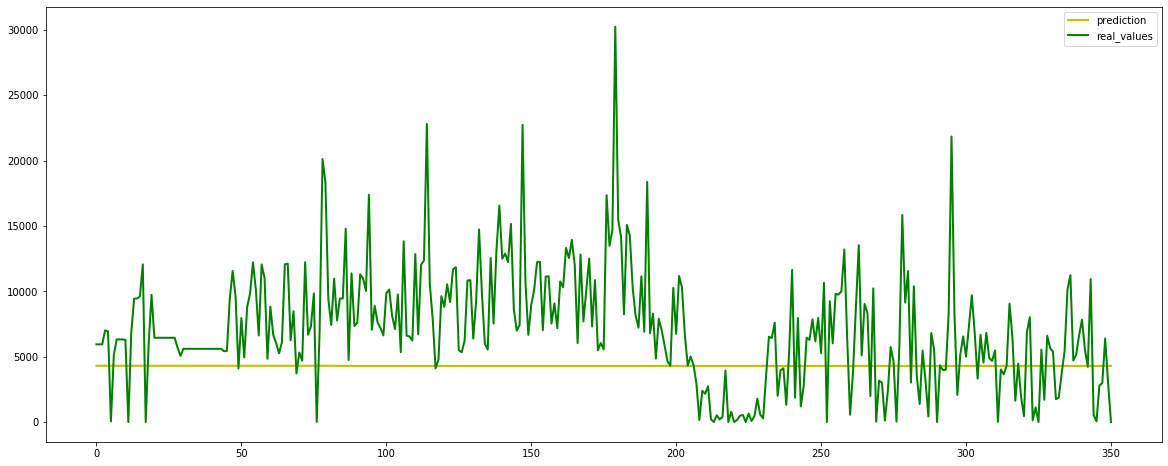

In [55]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

Prediction observed is pretty bad. This might have been due to not fitting the liear regression model based on the Year or Month as each observation would be unique. 

So lets create a Year and Month Column

In [67]:
dailysteps_user1_method1['Month'] = pd.DatetimeIndex(dailysteps_user1_method1['Date']).month
dailysteps_user1_method1['Year'] = pd.DatetimeIndex(dailysteps_user1_method1['Date']).year
dailysteps_user1_method1.head()

,Date,Steps,Month,Year
0,2014-12-07,2693.0,12,2014
1,2014-12-08,6567.0,12,2014
2,2014-12-09,6879.0,12,2014
3,2014-12-10,7845.0,12,2014
4,2014-12-11,916.0,12,2014


We will perform the same Linear Regression but instead of Date, we will use Year

In [68]:
y = method_1.loc[:,['Method_1']]
X = dailysteps_user1_method1.loc[:,['Year']]

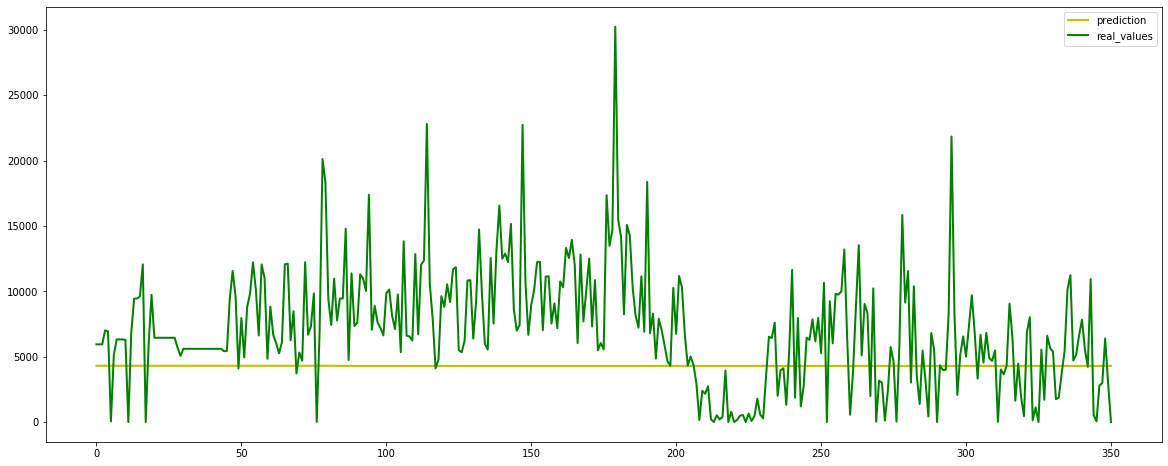

In [69]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

Performing a prediction using Year doesnt seem to have any effect. Maybe predicting by month would be better?

In [70]:
y = method_1.loc[:,['Method_1']]
X = dailysteps_user1_method1.loc[:,['Month']]

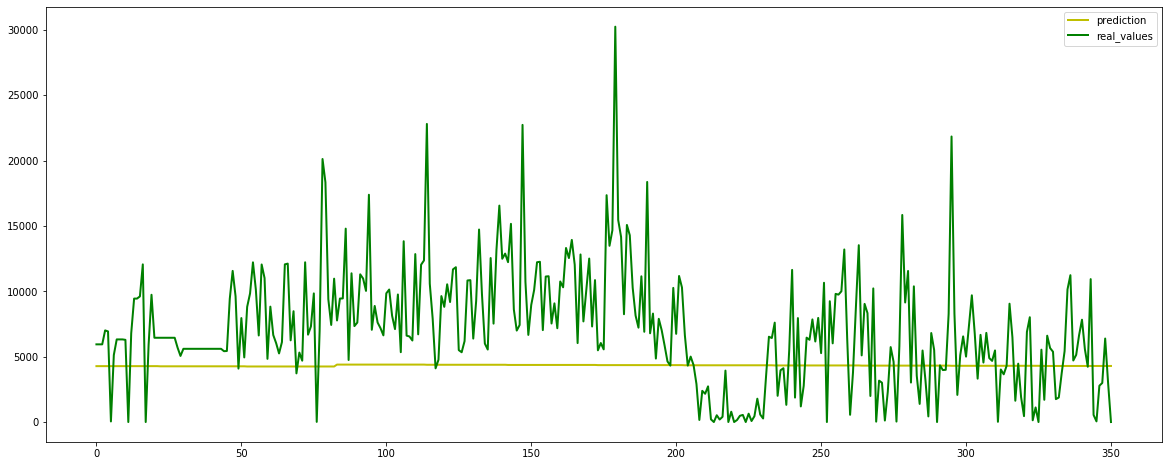

In [71]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

Doesn't appear to have any difference.

## Method 2 User 1

The same procedure and reasoning as in Method 1 before

In [311]:
y = method_2.loc[:,['Method_2']]
X = method_2.loc[:,['Date']]

Preparing the model for fitting

In [312]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [313]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [314]:
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

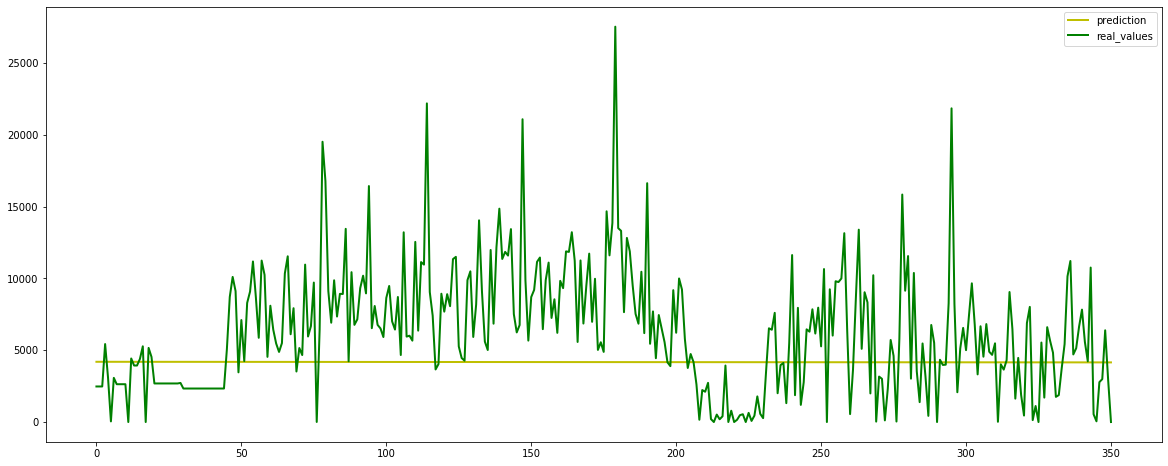

In [315]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

Again the Linear Regression prediction is very bad

## Method 3 User 1

The same procedure and reasoning as in Method 1 before

In [316]:
y = method_3.loc[:,['Method_3']]
X = method_3.loc[:,['Date']]

Preparing data for splitting

In [317]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [318]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [319]:
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)


### Plotting

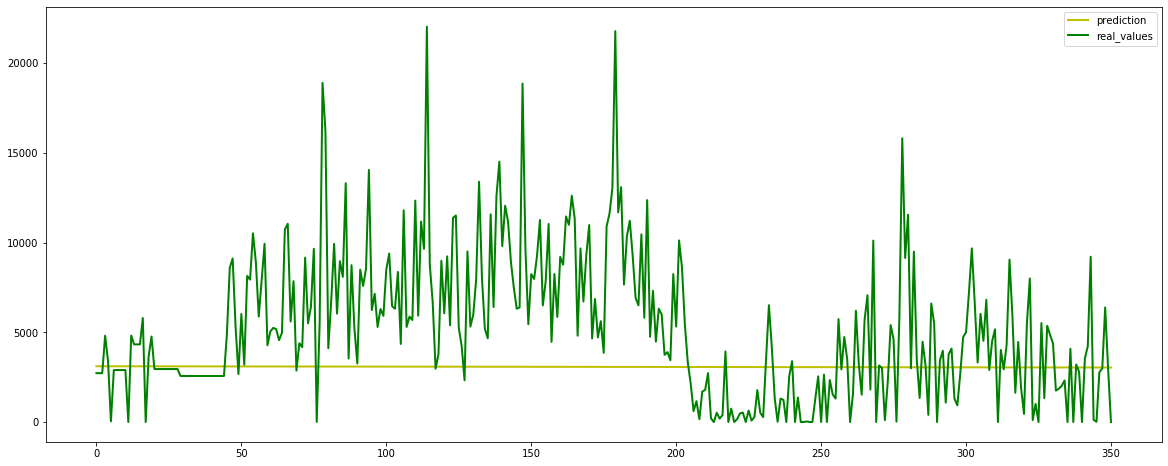

In [320]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

# User 2

Loading User 2 data

In [321]:
filename_user2 = "/Users/jeremytan/Desktop/Assignment_2/data/User2.csv"
df_user2 = read_QS_data(filename_user2)

In [322]:
# Taken from Ben's notebook
dailysteps_user2_method2 = run_method_2(df_user2)
dailysteps_user2_method1 = run_method_1(df_user2)
#Set Start and End Time Range
start_time = 8
end_time = 18
dailysteps_user2_method3 = run_method_3(df_user2, start_time, end_time)

In [323]:
# Merge the datasets together (Also taken from Ben's notebook)
dailysteps_user2_merged = dailysteps_user2_method1.merge(dailysteps_user2_method2,on ='Date').merge(dailysteps_user2_method3,on ='Date')
dailysteps_user2_merged.columns = [["Date", "Method_1", "Method_2", "Method_3"]]
dailysteps_user2_merged.head()

,Date,Method_1,Method_2,Method_3
0,2014-11-29,21427.000000,15087.532070,7088.666667
1,2014-11-30,4321.608069,2748.720461,2678.809798
2,2014-12-01,10473.112412,7404.569087,6489.632319
3,2014-12-02,15784.722998,10891.326965,11154.540779
4,2014-12-03,2783.602649,1914.052980,1646.644592


In [324]:
method_1 = dailysteps_user2_merged.loc[:,['Date', 'Method_1']]
method_2 = dailysteps_user2_merged.loc[:,['Date', 'Method_2']]
method_3 = dailysteps_user2_merged.loc[:,['Date', 'Method_3']]

## User 2 Method 1

In [325]:
y = method_1.loc[:,['Method_1']]
X = method_1.loc[:,['Date']]

Preparing data for splitting

In [326]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [327]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [328]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

### Plotting

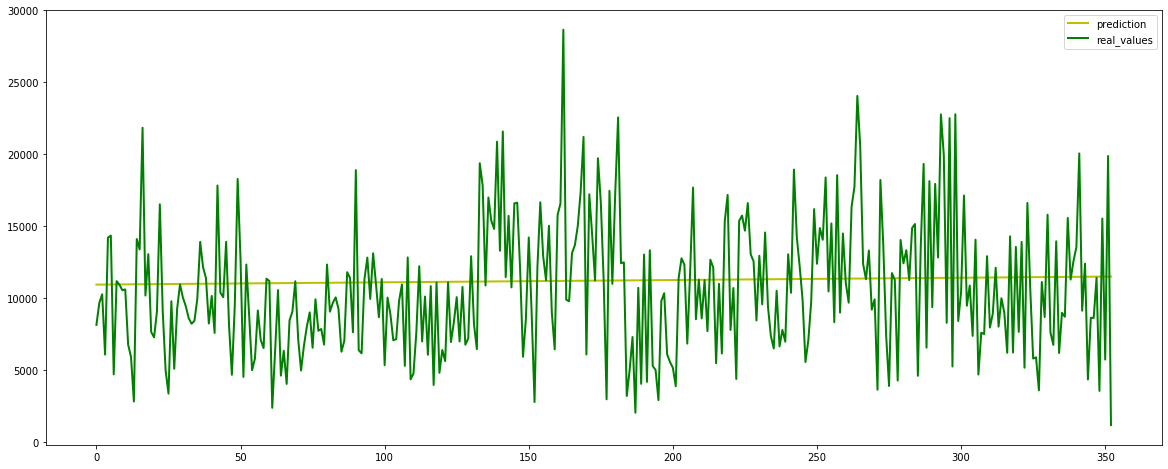

In [329]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

## User 2 Method 2

In [330]:
y = method_2.loc[:,['Method_2']]
X = method_2.loc[:,['Date']]

Preparing data for splitting

In [331]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [332]:
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [333]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

### Plotting

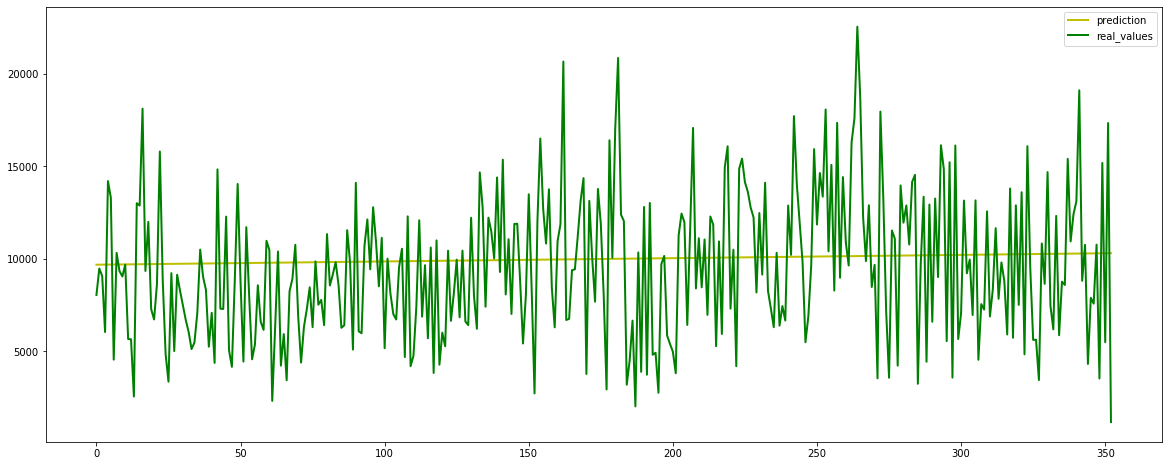

In [334]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

## User 2 Method 3

In [335]:
y = method_3.loc[:,['Method_3']]
X = method_3.loc[:,['Date']]

Preparing data for splitting

In [336]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [337]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [338]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

### Plotting

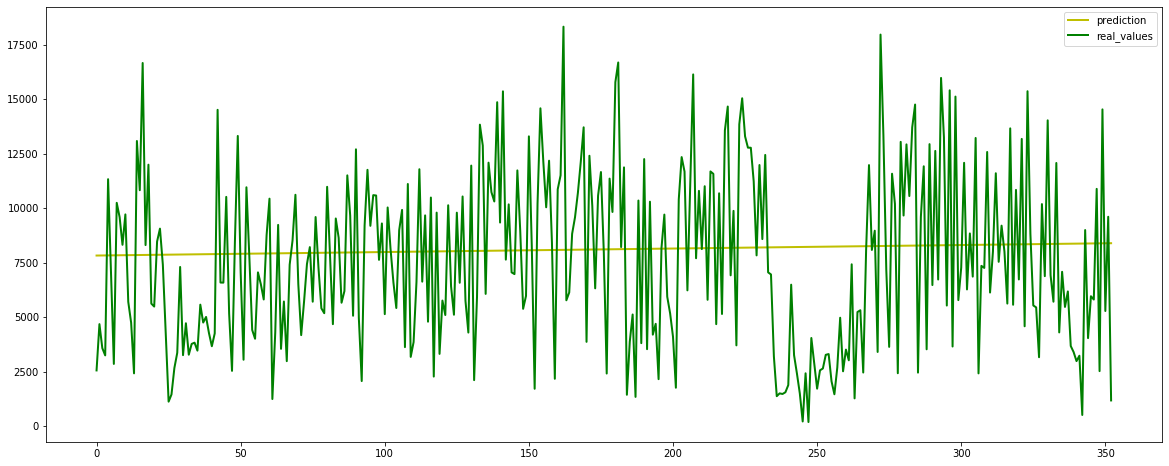

In [339]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

# SUSS

In [340]:
filename_suss = "/Users/jeremytan/Desktop/Assignment_2/data/SUSS.csv"
df_suss = read_QS_data(filename_suss)

In [341]:
# Taken from Ben's notebook
dailysteps_suss_method2 = run_method_2(df_suss)
dailysteps_suss_method1 = run_method_1(df_suss)
#Set Start and End Time Range
start_time = 8
end_time = 18
dailysteps_suss_method3 = run_method_3(df_suss, start_time, end_time)

In [342]:
# Merge the datasets together (Also taken from Ben's notebook)
dailysteps_suss_merged = dailysteps_suss_method1.merge(dailysteps_suss_method2,on ='Date').merge(dailysteps_suss_method3,on ='Date')
dailysteps_suss_merged.columns = [["Date", "Method_1", "Method_2", "Method_3"]]
dailysteps_suss_merged.head()

,Date,Method_1,Method_2,Method_3
0,2015-11-28,145.0,145.000000,145.000000
1,2015-11-29,4233.0,4115.703713,4080.573591
2,2015-11-30,4162.0,4013.000000,3906.552367
3,2015-12-01,3209.0,3191.000000,2979.000000
4,2015-12-02,2773.0,2724.000000,2544.000000


Creating Variables for Methods 1,2 and 3

In [343]:
method_1 = dailysteps_suss_merged.loc[:,['Date', 'Method_1']]
method_2 = dailysteps_suss_merged.loc[:,['Date', 'Method_2']]
method_3 = dailysteps_suss_merged.loc[:,['Date', 'Method_3']]

# SUSS Method 1

In [344]:
y = method_1.loc[:,['Method_1']]
X = method_1.loc[:,['Date']]

Preparing data for splitting

In [345]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [346]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [347]:
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

### Plotting

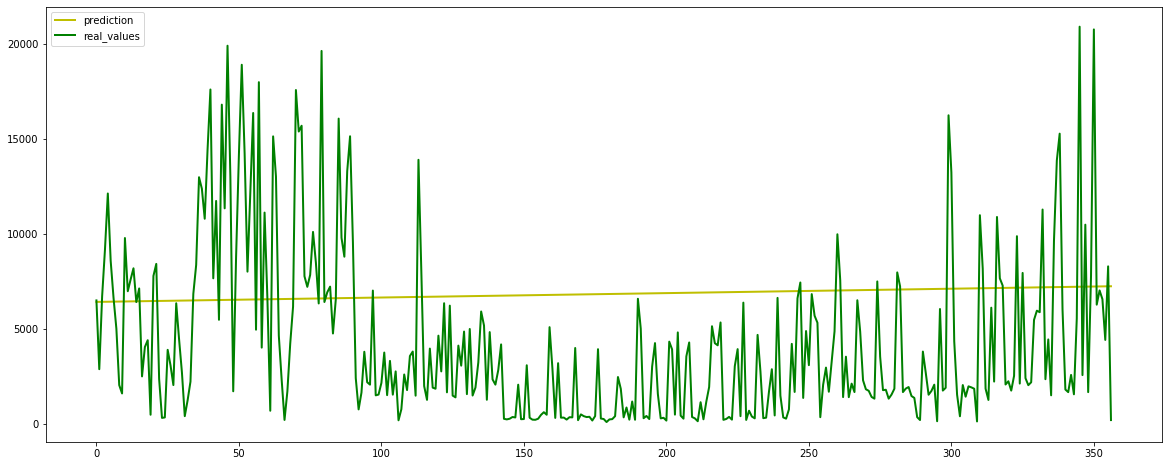

In [348]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

## SUSS Method 2

In [349]:
y = method_2.loc[:,['Method_2']]
X = method_2.loc[:,['Date']]

Preparing data for splitting

In [350]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [351]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [352]:
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

### Plotting

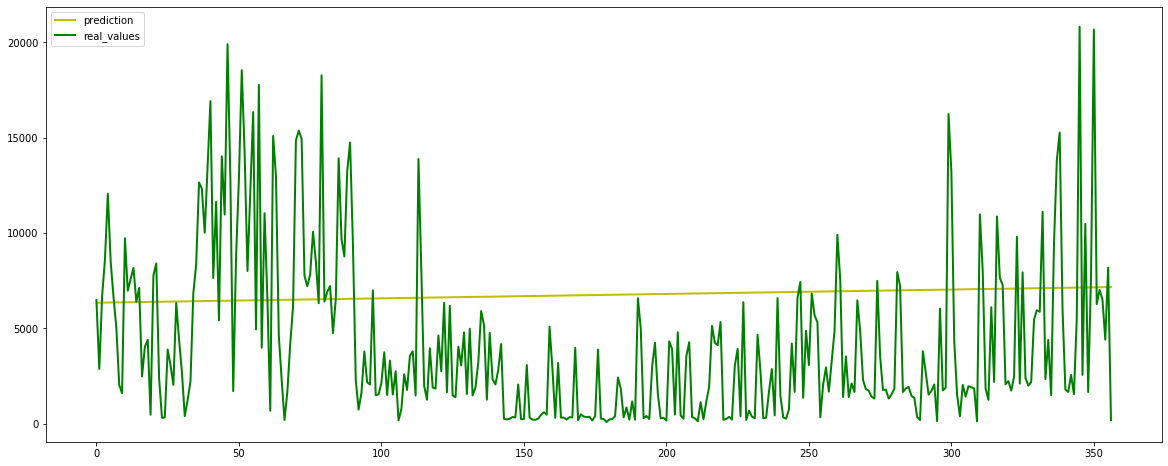

In [353]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

## SUSS Method 3

In [354]:
y = method_3.loc[:,['Method_3']]
X = method_3.loc[:,['Date']]

Preparing data for splitting

In [355]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

Splitting the data into testing and training data

In [356]:
# Selecting 20% size for the test data
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

Performing Linear Regression and Cross Validation

In [357]:
# Using Linear Regression
regressor = LinearRegression()
# Fitting the model
regressor.fit(X_train, y_train)
ts_cross_val = TimeSeriesSplit(n_splits=5)
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")
y_pred = regressor.predict(X_test)

### Plotting

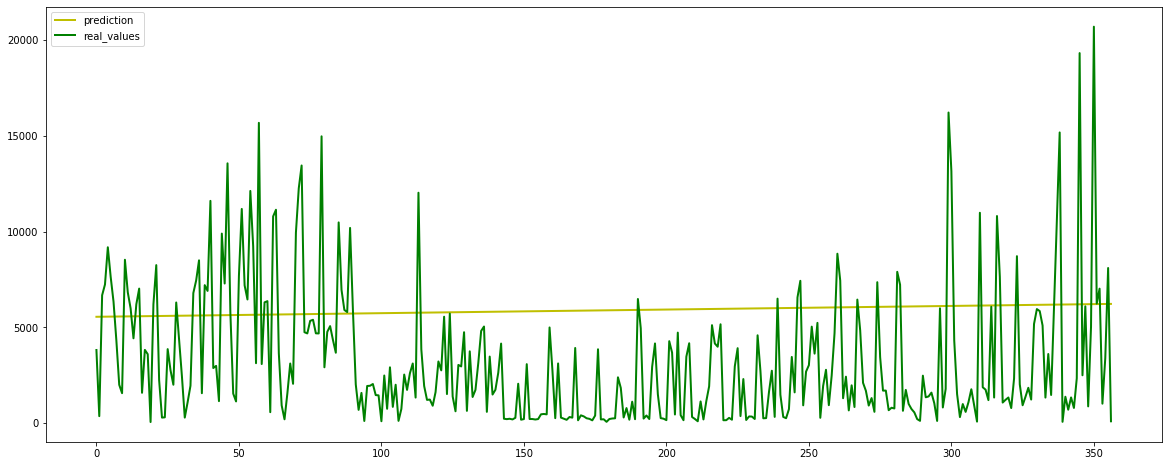

In [358]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")